In [3]:
import numpy as np
import autoinv.numpy as anp
import autoinv.graph as graph
import autoinv.core as core
from autoinv.numpy.numpy_wrapper import primitive

import numpy as _np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc
import inspect
from inspect import isfunction
import types
import itertools
%matplotlib inline

In [5]:
im = anp.array(sp.misc.imread('tiger.jpg'))/255.
im = anp.mean(im, axis=-1)

def im_process(my_im):
    
    gamma = 2.2
    my_im = my_im ** gamma
    
    white_level = .25
    my_im = white_level * my_im
#     my_im = my_im * white_level
    
    return my_im

def do_stuff(y):
    return y
    
    
# new_arr = core.trace(im_process, im)
new_arr = im_process(im)

graph.save_graph_pdf(new_arr.node)
core.print_trace(new_arr.node)

im_process_inv = core.make_inverse(im_process, im)
y = do_stuff(new_arr)
im_ = im_process_inv(y)

print 'DIFF {}'.format(anp.linalg.norm(im_-im))


<Node 4 for fn multiply. Called with Nodes [3] in positions [1]>
<Node 3 for fn power. Called with Nodes [2] in positions [0]>
<Node 2 for fn mean. Called with Nodes [1] in positions [0]>
<Node 1 for fn divide. Called with Nodes [0] in positions [0]>
<Node 0 for fn array. Called with Nodes [] in positions []>
New trace with value 0
Trace successful
Running inv for node <Node 7 for fn multiply. Called with Nodes [6] in positions [1]>, curr shape is (531, 945)
Running inv for node <Node 6 for fn power. Called with Nodes [5] in positions [0]>, curr shape is (531, 945)
Running inv for node <Start node>, curr shape is (531, 945)
DIFF 1.12348274516e-14


In [ ]:
def gen_box_filt(M, W):
    box = anp.zeros([M])
    box[M//2-W:M//2+W] = 1.
    box = box / anp.sum(box)
    box = anp.roll(box, M//2)
    return box

# @primitive
# def twiddle(x, omega):

#     x = np.swapaxes(x, -1, -2)
    
#     x0 = x[...,:,0] + x[...,:,1] * omega
#     x1 = x[...,:,0] - x[...,:,1] * omega
#     corr = np.concatenate([x0, x1], axis=-1)
    
#     return corr
    

# @primitive
# def inv_twiddle(ans, x, omega):
#     N = x.shape[-1]
#     def inv(y):
        
#         y0 = y[...,:N]
#         y1 = y[...,N:]
#         x0 = .5 * (y[...,:N] + y[...,N:])
#         x1 = .5 * (y[...,:N] - y[...,N:]) / omega
#         corr = np.stack([x0, x1], axis=-2)
#         return corr
#     return inv
# core.definv(twiddle, inv_twiddle)

def twiddle(x):

    N = x.shape[-1] + 0.
    omega = anp.exp(-2.j * anp.pi / (2*N) * anp.arange(0, N))
    a0 = anp.stack([anp.ones_like(omega),  omega], axis=-1)
    a1 = anp.stack([anp.ones_like(omega), -omega], axis=-1)
    a = anp.stack([a0, a1], axis=-2)

    x = anp.swapaxes(x, -1, -2)
    x = anp.expand_dims(x, -1)
    x = anp.matmul(a, x)
    x = anp.swapaxes(x, -2, -3)
    x = anp.reshape(x, list(x.shape[:-3]) + [-1])
    return x

def my_fft(x):
    if x.shape[-1] >= 2:
        x = anp.reshape(x, list(x.shape[:-1]) + [x.shape[-1]//2, 2])
        x = anp.swapaxes(x, -1, -2)
        x = my_fft(x)
        x = twiddle(x)
    return x

def my_fft2(x):
    x1 = my_fft(x)
    x2 = my_fft(anp.swapaxes(x1, -1, -2))
    x2 = anp.swapaxes(x2, -1, -2)
    return x2


M = 64
my_fft_inv = core.make_inverse(my_fft, anp.zeros(M))
    
x = anp.random.normal(size=[M])
y = my_fft(x)
# graph.save_graph_pdf(y.node)

x_ = my_fft_inv(y)
xf_ = my_fft_inv(y * my_fft(gen_box_filt(M, W=4)))

print 'FFT ERROR', np.linalg.norm(y - np.fft.fft(x))
print 'INVERSE ERROR', np.linalg.norm(x - x_)

X = anp.random.normal(size=[M,M])
print 'FFT2 ERROR', np.linalg.norm(my_fft2(X) - np.fft.fft2(X))
err = np.linalg.norm(core.make_inverse(my_fft2, anp.zeros([M,M]))(my_fft2(X)) - X)
print 'FFT2 Inv ERROR', err


plt.plot(anp.real(x).view(np.ndarray))
plt.plot(anp.real(xf_).view(np.ndarray))


New trace with value 7
Trace successful
New trace with value 7
Trace successful
Trace
New trace with value 7
Trace successful
Running inv for node <Node 2352 for fn reshape. Called with Nodes [2351] in positions [0]>, curr shape is (64,)
Running inv for node <Node 2351 for fn swapaxes. Called with Nodes [2350] in positions [0]>, curr shape is (2, 32, 1)
Running inv for node <Node 2350 for fn matmul. Called with Nodes [2349] in positions [1]>, curr shape is (32, 2, 1)
Running inv for node <Node 2349 for fn expand_dims. Called with Nodes [2348] in positions [0]>, curr shape is (32, 2, 1)
Running inv for node <Node 2348 for fn swapaxes. Called with Nodes [2332] in positions [0]>, curr shape is (32, 2)
Running inv for node <Node 2332 for fn reshape. Called with Nodes [2331] in positions [0]>, curr shape is (2, 32)
Running inv for node <Node 2331 for fn swapaxes. Called with Nodes [2330] in positions [0]>, curr shape is (2, 2, 16, 1)
Running inv for node <Node 2330 for fn matmul. Called wit

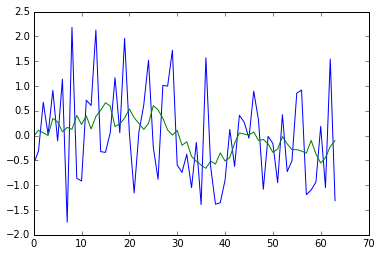

In [18]:
def gen_box_filt(M, W):
    box = anp.zeros([M])
    box[M//2-W:M//2+W] = 1.
    box = box / anp.sum(box)
    box = anp.roll(box, M//2)
    return box

# @primitive
# def twiddle(x, omega):

#     x = np.swapaxes(x, -1, -2)
    
#     x0 = x[...,:,0] + x[...,:,1] * omega
#     x1 = x[...,:,0] - x[...,:,1] * omega
#     corr = np.concatenate([x0, x1], axis=-1)
    
#     return corr
    

# @primitive
# def inv_twiddle(ans, x, omega):
#     N = x.shape[-1]
#     def inv(y):
        
#         y0 = y[...,:N]
#         y1 = y[...,N:]
#         x0 = .5 * (y[...,:N] + y[...,N:])
#         x1 = .5 * (y[...,:N] - y[...,N:]) / omega
#         corr = np.stack([x0, x1], axis=-2)
#         return corr
#     return inv
# core.definv(twiddle, inv_twiddle)

def twiddle(x):

    N = x.shape[-1] + 0.
    omega = anp.exp(-2.j * anp.pi / (2*N) * anp.arange(0, N))
    a0 = anp.stack([anp.ones_like(omega),  omega], axis=-1)
    a1 = anp.stack([anp.ones_like(omega), -omega], axis=-1)
    a = anp.stack([a0, a1], axis=-2)

    x = anp.swapaxes(x, -1, -2)
    x = anp.expand_dims(x, -1)
    x = anp.matmul(a, x)
    x = anp.swapaxes(x, -2, -3)
    x = anp.reshape(x, list(x.shape[:-3]) + [-1])
    return x

def my_fft(x):
    if x.shape[-1] >= 2:
        x = anp.reshape(x, list(x.shape[:-1]) + [x.shape[-1]//2, 2])
        x = anp.swapaxes(x, -1, -2)
        x = my_fft(x)
        x = twiddle(x)
    return x

def my_fft2(x):
    x1 = my_fft(x)
    x2 = my_fft(anp.swapaxes(x1, -1, -2))
    x2 = anp.swapaxes(x2, -1, -2)
    return x2


M = 64
my_fft2_inv = core.make_inverse(my_fft2, anp.zeros([M,M]))


my_fft_inv = core.make_inverse(my_fft, anp.zeros(M))
    
x = anp.array(anp.random.normal(size=[M]))
print 'Trace'
y = core.trace(my_fft, x)
graph.save_graph_pdf(y.node)

x_ = my_fft_inv(y)
xf_ = my_fft_inv(y * my_fft(gen_box_filt(M, W=4)))

print 'FFT ERROR', np.linalg.norm(y - np.fft.fft(x))
print 'INVERSE ERROR', np.linalg.norm(x - x_)

X = anp.random.normal(size=[M,M])
print 'FFT2 ERROR', np.linalg.norm(my_fft2(X) - np.fft.fft2(X))
err = np.linalg.norm(core.make_inverse(my_fft2, anp.zeros([M,M]))(my_fft2(X)) - X)
print 'FFT2 Inv ERROR', err


plt.plot(anp.real(x).view(np.ndarray))
plt.plot(anp.real(xf_).view(np.ndarray))


In [14]:
w = 480.
h = 320.
f = 380.
ppoint = anp.array([h, w]) * .5
rvec = anp.random.normal(size=[3])
tvec = anp.random.normal(size=[3])

N = 32

def rodrigues(r):
    theta = np.linalg.norm(r)
    k = r / theta
    K = np.array([[0, -k[2], k[1]], [k[2], 0, -k[0]], [-k[2], k[0], 0.]])
    R = np.eye(3) + np.sin(theta) * K + (1. - np.cos(theta)) * np.dot(K, K)
    return R
    
R = rodrigues(rvec)

# pts is [..., 2]
def intrinsic(pts):
    pts = pts - ppoint
    pts = pts / f
    pts = anp.concatenate([pts, -anp.ones(list(pts.shape[:-1]) + [1])], axis=-1)
    return pts

# pts is [..., 3]
def extrinsic(pts):
    pts = anp.expand_dims(pts, -1)
    pts = anp.matmul(R, pts)
    pts = anp.squeeze(pts, -1)
    pts = pts + tvec
    return pts

depths = 1. + np.abs(np.random.normal(size=[N, 1]))
@primitive
def reproject_pts(pts):
    return pts * depths

@primitive 
def project_pts(pts):
    return pts / anp.expand_dims(-pts[..., 2], -1)

core.definv(reproject_pts, (lambda ans, g : lambda g : project_pts(g)))

def pixels2world(pts):
    return extrinsic(reproject_pts(intrinsic(pts)))

world2pixels = core.make_inverse(pixels2world, anp.zeros([N, 2]))

pts = anp.array(anp.random.normal(size=[N, 2]))

pts3d = pixels2world(pts)
graph.save_graph_pdf(pts3d.node)
print '3d shape', pts3d.shape, pts.shape

pts_ = world2pixels(pts3d)

print np.linalg.norm(pts_ - pts)
t = intrinsic(pts)
print t.node, pts.node
intrinsic_inv = core.make_inverse(intrinsic, pts)
print 'intrinsic inv', np.linalg.norm(pts - intrinsic_inv(t))
extrinsic_inv = core.make_inverse(extrinsic, pts3d)
t = extrinsic(pts3d)
print 'extrinsic inv', np.linalg.norm(pts3d - extrinsic_inv(t))

pts_ = intrinsic_inv(project_pts(extrinsic_inv(extrinsic(reproject_pts(intrinsic(pts))))))
print 'all inv', np.linalg.norm(pts - pts_)

New trace with value 4
Trace successful
3d shape (32, 3) (32, 2)
Running inv for node <Node 669 for fn add. Called with Nodes [668] in positions [0]>, curr shape is (32, 3)
Running inv for node <Node 668 for fn squeeze. Called with Nodes [667] in positions [0]>, curr shape is (32, 3)
Running inv for node <Node 667 for fn matmul. Called with Nodes [666] in positions [1]>, curr shape is (32, 3, 1)
Running inv for node <Node 666 for fn expand_dims. Called with Nodes [665] in positions [0]>, curr shape is (32, 3, 1)
Running inv for node <Node 665 for fn reproject_pts. Called with Nodes [664] in positions [0]>, curr shape is (32, 3)
Running inv for node <Node 664 for fn concatenate_args. Called with Nodes [661] in positions [1]>, curr shape is (32, 3)
Concatenate inv. Slicing from 0 to 2 on axis -1.
Running inv for node <Node 661 for fn divide. Called with Nodes [660] in positions [0]>, curr shape is (32, 2)
Running inv for node <Node 660 for fn subtract. Called with Nodes [659] in position

In [25]:
def rodrigues(r):
    theta = np.linalg.norm(r)
    k = r / theta
    K = np.array([[0, -k[2], k[1]], [k[2], 0, -k[0]], [-k[2], k[0], 0.]])
    R = np.eye(3) + np.sin(theta) * K + (1. - np.cos(theta)) * np.dot(K, K)
    return R

# pts.shape is [..., 2]
def pix2cam(ppoint, f):
    def fun(pts):
        pts = pts - ppoint
        pts = pts / f
        pts = anp.concatenate([pts, -anp.ones(list(pts.shape[:-1]) + [1])], axis=-1)
        return pts
    return fun

# pts.shape is [..., 3]
def cam2world(rvec, tvec):
    R = rodrigues(rvec)
    def fun(pts):
        pts = anp.expand_dims(pts, -1)
        pts = anp.matmul(R, pts)
        pts = anp.squeeze(pts, -1)
        pts = pts + tvec
        return pts
    return fun

def reproject_pts(depths):
    def fun(pts):
        return pts * depths
    return fun

@primitive 
def project_pts(pts):
    return pts / anp.expand_dims(-pts[..., 2], -1)

def pix2world(ppoint, f, rvec, tvec, depths):
    reproj_fn = primitive(reproject_pts(depths))
    core.definv(reproj_fn, (lambda ans, g : lambda g : project_pts(g)))
    def fun(pts):
        return cam2world(rvec, tvec)(reproj_fn(pix2cam(ppoint, f)(pts)))
    return fun
    
def pix2pix(ppoint, f, rt0, rt1):
    def ret_fn(pts, depths):
        p2w_0 = pix2world(ppoint, f, rt0[:,0], rt0[:,1], depths)
        p2w_1 = pix2world(ppoint, f, rt1[:,0], rt1[:,1], anp.zeros_like(depths))
        w2p_1 = core.make_inverse(p2w_1, pts)
        return w2p_1(p2w_0(pts))
    return ret_fn
            
    
    
w = 480.
h = 320.
f = 380.
ppoint = anp.array([h, w]) * .5

rt0 = anp.random.normal(size=[3,2])
rt1 = anp.random.normal(size=[3,2])

N = 32
    
depths = 1. + np.abs(np.random.normal(size=[N, 1]))
p2w_0 = pix2world(ppoint, f, rt0[:,0], rt0[:,1], depths)

p2w_1 = pix2world(ppoint, f, rt1[:,0], rt1[:,1], anp.zeros_like(depths))
w2p_1 = core.make_inverse(p2w_1, anp.zeros([N, 2]))

p2p_00 = pix2pix(ppoint, f, rt0, rt0)

# This fn will project points from camera 0 into camera 1
p2p_01 = lambda pts : w2p_1(p2w_0(pts))

pts = anp.array(anp.random.normal(size=[N, 2]))
pts_ = w2p_0(p2w_0(pts))
print np.linalg.norm(pts-p2p_00(pts, depths))

New trace with value 7
Trace successful
Running inv for node <Node 3870 for fn add. Called with Nodes [3869] in positions [0]>, curr shape is (32, 3)
Running inv for node <Node 3869 for fn squeeze. Called with Nodes [3868] in positions [0]>, curr shape is (32, 3)
Running inv for node <Node 3868 for fn matmul. Called with Nodes [3867] in positions [1]>, curr shape is (32, 3, 1)
Running inv for node <Node 3867 for fn expand_dims. Called with Nodes [3866] in positions [0]>, curr shape is (32, 3, 1)
Running inv for node <Node 3866 for fn fun. Called with Nodes [3865] in positions [0]>, curr shape is (32, 3)
Running inv for node <Node 3865 for fn concatenate_args. Called with Nodes [3862] in positions [1]>, curr shape is (32, 3)
Concatenate inv. Slicing from 0 to 2 on axis -1.
Running inv for node <Node 3862 for fn divide. Called with Nodes [3861] in positions [0]>, curr shape is (32, 2)
Running inv for node <Node 3861 for fn subtract. Called with Nodes [3860] in positions [0]>, curr shape 

In [ ]:
im = anp.array(sp.misc.imread('tiger.jpg')) / 255.
N = 16
my_im = im[:im.shape[0]//N*N, :im.shape[1]//N*N, ...]

my_im = my_im + 0

def mess(my_im):
    sh = my_im.shape
    my_im = anp.reshape(my_im, [sh[0]//N, N, sh[1]//N, N, -1])
    # my_im = my_im.transpose([0, 2, 1, 3, 4])
    my_im = anp.transpose(my_im, [0, 2, 1, 3, 4])
    my_im = anp.reshape(my_im, [sh[0]//N, sh[1]//N, N**2, -1])
    my_im = anp.add(my_im, .5)
    return my_im

output = mess(my_im)

# graph.save_graph_pdf(output.node)
# print '\n'
# core.print_trace(output.node)
# print '\n'



new_arr = anp.expand_dims(anp.mean(output, axis=-2), axis=-2)
new_arr = anp.tile(new_arr, [1, 1, N**2, 1])
graph.save_graph_pdf(new_arr.node)

print new_arr.shape
inv_fn = core.make_inverse(mess, my_im)
test = inv_fn(new_arr)
print test.shape


# test_fn = build_inverse(my_im.node)
# print 'inverse built'
# back_im = test_fn(new_arr)
# print im.shape, back_im.shape

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(im, interpolation='none')
plt.subplot(122)
plt.imshow(test, interpolation='none')
plt.show()

In [ ]:
for k in core.primitive_invs:
    print k

In [ ]:

N = 16

t_ = anp.linspace(-.1,.1,N)
t = anp.reshape(t_, [-1, 1])

def test_fn(t):
    x = anp.tile(t, [1, N])
    x = x - .5 * anp.ones(x.shape)
    y = anp.tile(anp.reshape(t, [1, -1]), [N, 1])
    print t.shape, x.shape, y.shape
    g = anp.exp(anp.add(anp.square(x), anp.square(y)))
    f = anp.divide(g, anp.sum(g))
    f = f + anp.ones(f.shape)
    return f 

# t.trace = 0
# f = test_fn(t)
# print 'Trace', f.trace

# plt.imshow(f)
# plt.colorbar()


f = core.trace(test_fn, t)
print f.trace, f.node

plt.imshow(f)

# stack = [f.node]
# finished = [f.node.id]
# print 'Trace!!!!!'
# while stack:
#     print 'Stack is', [n.id for n in stack]
#     node = stack.pop()
#     if node is None:
#         print 'ABORT NONE ?!'
#     print node.id, node.fun.__name__, len(node.parents), 'parents', node
#     print len(node.parents), [n.id for n in node.parents] if node.parents else []
#     for n in node.parents:
#         if n not in finished:
#             stack.append(n)

core.print_trace(f.node)
graph.save_graph_pdf(f.node)

In [ ]:
test = anp.zeros([5,5])
print test._trace
test = anp.add(anp.random.normal(size=[5,5]), 0.)

print test._trace

In [ ]:
print anp.add
print anp.random
print anp.random.normal

In [ ]:
test = anp.zeros([5,5])
test = test - 0.
test = test + anp.random.normal(size=test.shape)
test = test * 1
graph.save_graph_pdf(test.node)

In [ ]:
print anp.find_top_boxed_args

In [ ]:
ramp = anp.linspace(0, 10, 10, endpoint=False)
print ramp

def basic(t):
    return ((t + 1) / 2.) ** .5

y = basic(ramp)
print y

inv_fn = core.make_inverse(basic, ramp)
print inv_fn(y)

In [ ]:
M = 8
my_arr = anp.arange(M)
print 'We start with the range from 0 to M-1:'

def butterfly(x):
    x = anp.reshape(x, [1,-1])

    while x.shape[1] > 1:
        sh = x.shape
        x = anp.reshape(x, [sh[0], sh[1]//2, 2])
        x = anp.transpose(x, [0, 2, 1])
        x = anp.reshape(x, [sh[0]*2, sh[1]//2])
        
    return x

@primitive
def complex_fold(x):
    N = x.shape[-1] + 0.
    omega = np.exp(-2.j * anp.pi / N * np.arange(0, N))
    x0 = x[:,0,:] + x[:,1,:] * omega
    x1 = x[:,0,:] - x[:,1,:] * omega
    return np.concatenate([x0, x1], axis=-1)

# @primitive
# def complex_fold_inv(ans, x):
#     N = x.shape[-1]
#     omega = np.exp(-2.j * anp.pi / N * np.arange(0, N, dtype=np.float32))
#     def cf_inv(g):
#         y0 = g[:,:N]
#         y1 = g[:,N:]
#         x0 = .5 * (y0 + y1)
#         x1 = .5 * (y0 - y1) / omega
#         return np.stack([x0, x1], axis=1)
#     return cf_inv

# core.definv(complex_fold, complex_fold_inv)
    

def my_fft(x):
    x = butterfly(x)
    
    while x.shape[0] > 1:
        sh = x.shape
        x = anp.reshape(x, [sh[0]//2, 2, -1])
        x = complex_fold(x)
        
    return x
        
    
print 'Now it is in radix-2 ordering, ready for an FFT:'
b = butterfly(my_arr)
print b.shape, b.T
    
inv_fn = core.make_inverse(butterfly, my_arr)
back_arr = inv_fn(butterfly(my_arr))
print 'Now it is back in order:'
print back_arr

In [ ]:
t = my_fft(my_arr)
print my_arr.shape, t.shape
print t
t_ = np.fft.fft(my_arr)
print t_
print np.sum(np.abs(t-t_))

plt.plot(np.log(1+np.abs(t.view(np.ndarray))))
# plt.plot(np.abs(t_.view(np.ndarray)))

In [ ]:
def down2(im):
    im = im[:im.shape[0]//2*2, :im.shape[1]//2*2, ...]
    im = anp.reshape(im, [im.shape[0]//2, 2, im.shape[1]//2, 2] + list(im.shape[2:]))
    return anp.mean(anp.mean(im, axis=3), axis=1)

im = anp.array(sp.misc.imread('tiger.jpg')) / 255.
im = down2(down2(im))
im = anp.mean(im, -1)
N = 16
im = im[:im.shape[0]//N*N, :im.shape[1]//N*N, ...]

T = 8
im_stack = anp.tile(anp.expand_dims(im, -1), T)
for t in range(T):
    if t > 0 and anp.random.uniform() < 2./T:
        xy = anp.array(anp.random.randint(-16, 16, size=[2]))
    else:
        xy = anp.array(anp.random.randint(-2, 2, size=[2]))
    print xy._trace
    im_ = im_stack[..., t]
    im_stack[..., t] = anp.roll(im_, xy, axis=[0,1])
    
plt.imshow(anp.mean(im_stack, axis=-1).view(np.ndarray), cmap='gray')

In [ ]:
def rcwindow(N):
    x = np.linspace(0., N, N, endpoint=False)
    rcw = .5 - .5 * np.cos(2.*np.pi * (x + .5) / N)
    rcw = rcw.reshape((N,1)) * rcw.reshape((1,N))
    return rcw

def hdrplus_merge(imgs, c, sig):
    # imgs is [..., h, w, ch]
    rcw = rcwindow(imgs.shape[-2])[...,np.newaxis]
    imgs = imgs * rcw
    imgs_f = np.fft.fft2(imgs, axes=(-3,-2))
    Dz2 = np.square(np.abs(imgs_f[...,0:1] - imgs_f))
    Az = Dz2 / (Dz2 + c*sig**2)
    filts = 1 - Az
    filts[...,0] = 1 + np.sum(Az[...,1:], axis=-1)
    output_f = np.mean(imgs_f * filts, axis=-1)
    output_f = np.real(np.fft.ifft2(output_f))
    
    return output_f

    
def hdrplus_tiled(noisy, c, sig, N):
    sh = noisy.shape[0:2]
    buffer = np.zeros_like(noisy[...,0])
    
    for i in range(2):
        for j in range(2):
    
            def patchify(noisy):
                hpatches = anp.roll(noisy, shift=anp.array([-N//2*i, -N//2*j]), axis=(0,1))
                hpatches = anp.reshape(hpatches, [sh[0]//N, N, sh[1]//N, N] + list(hpatches.shape[2:]))
                hpatches = anp.swapaxes(hpatches, 2, 1)
                return hpatches
            
            hpatches = patchify(noisy)
            
            merged = hdrplus_merge(hpatches, c, sig)               
            
            auto_inv = True
            if auto_inv:
                merged = core.make_inverse(patchify, noisy[...,0])(merged)
            else:
                merged = np.transpose(merged, [0,2,1,3])
                merged = np.reshape(merged, sh)
                merged = np.roll(merged, shift=(N//2*i, N//2*j), axis=(0,1))
            
            buffer += merged
    return buffer

In [ ]:

sig = .05
noisy = im_stack + anp.random.normal(size=im_stack.shape) * sig
print noisy.shape
filtered = hdrplus_tiled(noisy, 10**2.5, sig, 16)

plt.imshow(anp.mean(noisy, axis=-1).view(np.ndarray), cmap='gray')
plt.show()
plt.imshow(filtered.view(np.ndarray), cmap='gray')


In [ ]:
t = anp.linspace(-1,1.,21)
print t._trace
t = anp.roll(t, 2, axis=0)
# t = 1. + t

In [ ]:
a = np.ones([5,8,4,3])
b = np.ones([7,8,2,4])
print a.shape, b.shape
c = np.tensordot(a, b, axes=[[1,2],[1,3]])
print c.shape

In [ ]:
im0 = np.array(sp.misc.imread('/Users/ben/berkeley/google17/supplement/real_results_png/img_0_0_ref.png'))
im1 = np.array(sp.misc.imread('/Users/ben/berkeley/google17/supplement/real_results_png/img_0_5_ours_kpn.png'))
def crop(im, y, x, N=256):
    return im[y-N:y+N, x-N:x+N]
y, x = 420, 1180
plt.imshow(crop(im0, y, x), cmap='gray', interpolation='none')
plt.show()
plt.imshow(crop(im1, y, x), cmap='gray', interpolation='none')

sp.misc.imsave('/Users/ben/berkeley/www_reboot/kpn0.png', crop(im0, y, x))
sp.misc.imsave('/Users/ben/berkeley/www_reboot/kpn1.png', crop(im1, y, x))